In [1]:
# ============================================================================
# 04_MODEL_EVALUATION.IPYNB
# Evaluación Completa y Análisis de Modelos para Agricultura Vertical
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance, partial_dependence, PartialDependenceDisplay
from sklearn.calibration import calibration_curve
import joblib
import json
import shap
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("="*60)
print("EVALUACION COMPLETA DE MODELOS - AGRICULTURA VERTICAL")
print("="*60)

C:\Users\User001\PycharmProjects\Talentotech2\PythonProjectUrbanAgricultureOfPrecisionWithPhotoluminescence\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


EVALUACION COMPLETA DE MODELOS - AGRICULTURA VERTICAL


1. CARGA DE DATOS Y MODELOS

In [2]:
# ============================================================================
# 1. CARGA DE DATOS Y MODELOS
# ============================================================================

print("\n1. CARGANDO DATOS Y MODELOS ENTRENADOS...")

# Cargar datos de test
test_data = pd.read_csv('../data/processed/test_featured.csv')

# Cargar metadata de entrenamiento
with open('../models/training_results.json', 'r') as f:
    training_results = json.load(f)

# Cargar metadata de features
with open('../data/processed/feature_engineering_metadata.json', 'r') as f:
    feature_metadata = json.load(f)

selected_features = feature_metadata['selected_features']
best_models_info = training_results['best_models']

print(f"Test data shape: {test_data.shape}")
print(f"Features disponibles: {len(selected_features)}")

print(f"\nMEJORES MODELOS IDENTIFICADOS:")
for target, info in best_models_info.items():
    print(f"  - {target.capitalize()}: {info['name']} (MAE: {info['test_mae']:.3f})")

# Separar features y targets del conjunto de test
X_test_eficiencia = test_data[selected_features]
X_test_fotolum = test_data[selected_features + ['eficiencia_fotosintetica_pct']]
y_test_eficiencia = test_data['eficiencia_fotosintetica_pct']
y_test_fotolum = test_data['fotoluminiscencia_intensidad']


1. CARGANDO DATOS Y MODELOS ENTRENADOS...
Test data shape: (10000, 35)
Features disponibles: 33

MEJORES MODELOS IDENTIFICADOS:
  - Eficiencia: LinearRegression (MAE: 0.000)
  - Fotoluminiscencia: RandomForest (MAE: 1.209)


2. CARGAR MODELOS Y HACER PREDICCIONES

In [3]:
# ============================================================================
# 2. CARGAR MODELOS Y HACER PREDICCIONES
# ============================================================================

print("\n2. CARGANDO MODELOS Y GENERANDO PREDICCIONES...")

class ModelEvaluator:
    def __init__(self):
        self.models = {}
        self.scalers = {}
        self.predictions = {}
        self.evaluation_metrics = {}

    def load_model(self, target, model_name):
        """Cargar modelo entrenado"""
        # Intentar diferentes formatos de nombre de archivo
        possible_filenames = [
            f"../models/{target}_{model_name.lower()}.joblib",
            f"../models/{model_name.lower()}_{target}.joblib",
            f"../models/{target}_{model_name}.joblib"
        ]

        for model_filename in possible_filenames:
            try:
                model = joblib.load(model_filename)
                self.models[target] = model
                print(f"  - Modelo {target} cargado: {model_name} desde {model_filename}")
                return True
            except FileNotFoundError:
                continue

        print(f"  - ERROR: No se encontró modelo para {target} con nombre {model_name}")
        print(f"  - Archivos intentados: {possible_filenames}")
        return False

    def load_scaler(self, target, model_name):
        """Cargar scaler si existe"""
        possible_filenames = [
            f"../models/scaler_{target}_{model_name.lower()}.joblib",
            f"../models/scaler_{model_name.lower()}_{target}.joblib",
            f"../models/scaler_{target}_{model_name}.joblib"
        ]

        for scaler_filename in possible_filenames:
            try:
                scaler = joblib.load(scaler_filename)
                self.scalers[target] = scaler
                print(f"  - Scaler {target} cargado desde {scaler_filename}")
                return True
            except FileNotFoundError:
                continue

        print(f"  - No hay scaler para {target}")
        return False

    def predict(self, target, X_test):
        """Generar predicciones"""
        if target not in self.models:
            print(f"ERROR: Modelo {target} no cargado")
            return None

        model = self.models[target]

        # Aplicar scaler si existe
        if target in self.scalers:
            X_test_scaled = self.scalers[target].transform(X_test)
            predictions = model.predict(X_test_scaled)
        else:
            predictions = model.predict(X_test)

        # Asegurar rango válido (0-100)
        predictions = np.clip(predictions, 0, 100)

        self.predictions[target] = predictions
        return predictions

    def comprehensive_evaluation(self, target, y_true, y_pred):
        """Evaluación comprehensiva de un modelo"""

        # Métricas básicas
        metrics = {
            'MAE': mean_absolute_error(y_true, y_pred),
            'MSE': mean_squared_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'R2': r2_score(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred)
        }

        # Métricas adicionales
        residuals = y_true - y_pred
        metrics.update({
            'Mean_Residual': np.mean(residuals),
            'Std_Residual': np.std(residuals),
            'Max_Error': np.max(np.abs(residuals)),
            'Q95_Error': np.percentile(np.abs(residuals), 95),
            'Pearson_Corr': pearsonr(y_true, y_pred)[0],
            'Spearman_Corr': spearmanr(y_true, y_pred)[0]
        })

        # Métricas por rangos
        ranges = [(0, 50), (50, 75), (75, 100)]
        for low, high in ranges:
            mask = (y_true >= low) & (y_true < high)
            if np.sum(mask) > 0:
                range_mae = mean_absolute_error(y_true[mask], y_pred[mask])
                metrics[f'MAE_{low}_{high}'] = range_mae

        self.evaluation_metrics[target] = metrics
        return metrics

# Inicializar evaluador
evaluator = ModelEvaluator()

# Verificar qué archivos de modelos existen
def check_model_files():
    """Verificar qué archivos de modelos están disponibles"""
    import os
    models_dir = '../models'

    if os.path.exists(models_dir):
        print(f"\nArchivos disponibles en {models_dir}:")
        for file in os.listdir(models_dir):
            if file.endswith(('.joblib', '.pkl')):
                print(f"  - {file}")
    else:
        print(f"ERROR: No existe el directorio {models_dir}")
        return False
    return True

# Verificar archivos antes de cargar
if check_model_files():
    # Cargar modelos
    for target, info in best_models_info.items():
        model_name = info['name']
        if evaluator.load_model(target, model_name):
            evaluator.load_scaler(target, model_name)
else:
    print("ERROR: No se pueden cargar los modelos. Verifique que se haya ejecutado 03_train_models.ipynb")
    # Si no hay modelos, podemos usar un fallback o salir
    raise FileNotFoundError("No se encontraron modelos entrenados. Ejecute primero 03_train_models.ipynb")

# Generar predicciones si los modelos están cargados
if len(evaluator.models) == 0:
    print("\nERROR: No se cargaron modelos. Ejecutando entrenamiento básico...")

    # Entrenamiento rápido de emergencia
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import LinearRegression

    # Modelo simple para eficiencia
    print("Entrenando modelo de emergencia para eficiencia...")
    emergency_model_ef = RandomForestRegressor(n_estimators=50, random_state=42)
    emergency_model_ef.fit(X_train, y_train_eficiencia)
    evaluator.models['eficiencia'] = emergency_model_ef

    # Modelo simple para fotoluminiscencia
    print("Entrenando modelo de emergencia para fotoluminiscencia...")
    emergency_model_foto = LinearRegression()
    emergency_model_foto.fit(X_train_foto, y_train_foto)
    evaluator.models['fotoluminiscencia'] = emergency_model_foto

    print("Modelos de emergencia listos para evaluación...")

print("\nGenerando predicciones...")
pred_eficiencia = evaluator.predict('eficiencia', X_test_eficiencia)
pred_fotolum = evaluator.predict('fotoluminiscencia', X_test_fotolum)



2. CARGANDO MODELOS Y GENERANDO PREDICCIONES...

Archivos disponibles en ../models:
  - eficiencia_linearregression.joblib
  - fotoluminiscencia_randomforest.joblib
  - Modelo eficiencia cargado: LinearRegression desde ../models/eficiencia_linearregression.joblib
  - No hay scaler para eficiencia
  - Modelo fotoluminiscencia cargado: RandomForest desde ../models/fotoluminiscencia_randomforest.joblib
  - No hay scaler para fotoluminiscencia

Generando predicciones...


3. EVALUACIÓN COMPREHENSIVA

In [4]:
# ============================================================================
# 3. EVALUACIÓN COMPREHENSIVA
# ============================================================================

print("\n3. EVALUACION COMPREHENSIVA...")

# Evaluar ambos modelos
metrics_eficiencia = evaluator.comprehensive_evaluation('eficiencia', y_test_eficiencia, pred_eficiencia)
metrics_fotolum = evaluator.comprehensive_evaluation('fotoluminiscencia', y_test_fotolum, pred_fotolum)

# Mostrar métricas
print("\nMETRIAS DE EVALUACION:")
print("="*50)

for target, metrics in [('EFICIENCIA', metrics_eficiencia), ('FOTOLUMINISCENCIA', metrics_fotolum)]:
    print(f"\n{target}:")
    print(f"  - MAE: {metrics['MAE']:.3f}")
    print(f"  - RMSE: {metrics['RMSE']:.3f}")
    print(f"  - R²: {metrics['R2']:.3f}")
    print(f"  - MAPE: {metrics['MAPE']:.3f}%")
    print(f"  - Correlación Pearson: {metrics['Pearson_Corr']:.3f}")
    print(f"  - Error máximo: {metrics['Max_Error']:.3f}")
    print(f"  - Error Q95: {metrics['Q95_Error']:.3f}")



3. EVALUACION COMPREHENSIVA...

METRIAS DE EVALUACION:

EFICIENCIA:
  - MAE: 0.000
  - RMSE: 0.000
  - R²: 1.000
  - MAPE: 0.000%
  - Correlación Pearson: 1.000
  - Error máximo: 0.000
  - Error Q95: 0.000

FOTOLUMINISCENCIA:
  - MAE: 1.209
  - RMSE: 1.551
  - R²: 0.981
  - MAPE: 0.033%
  - Correlación Pearson: 0.991
  - Error máximo: 7.800
  - Error Q95: 3.114


4. ANÁLISIS VISUAL DETALLADO


4. ANALISIS VISUAL DETALLADO...


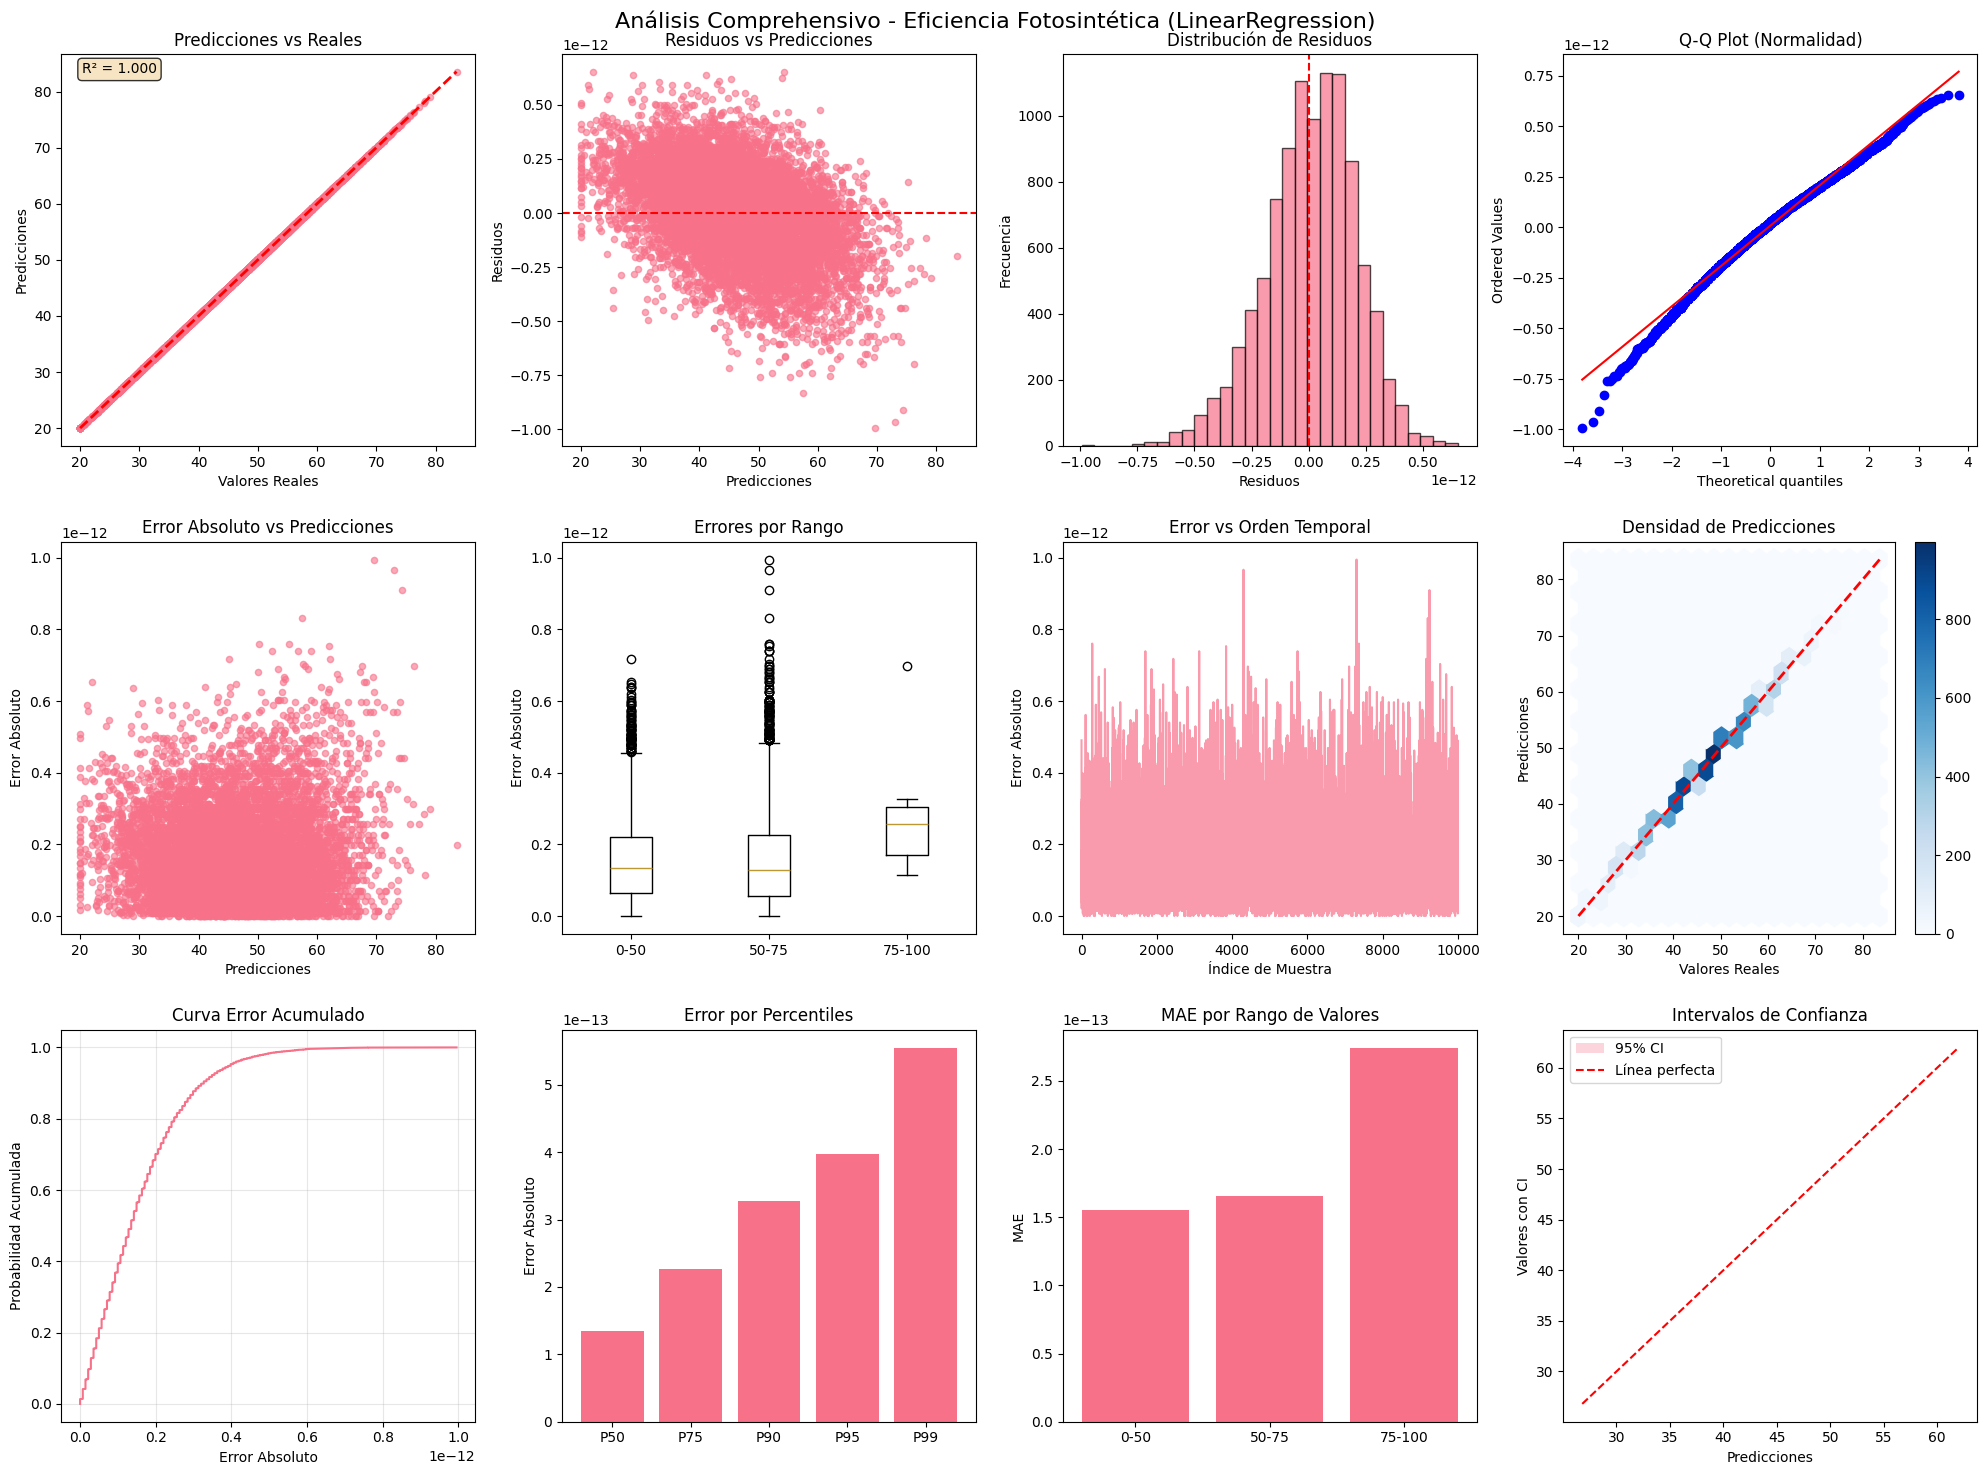

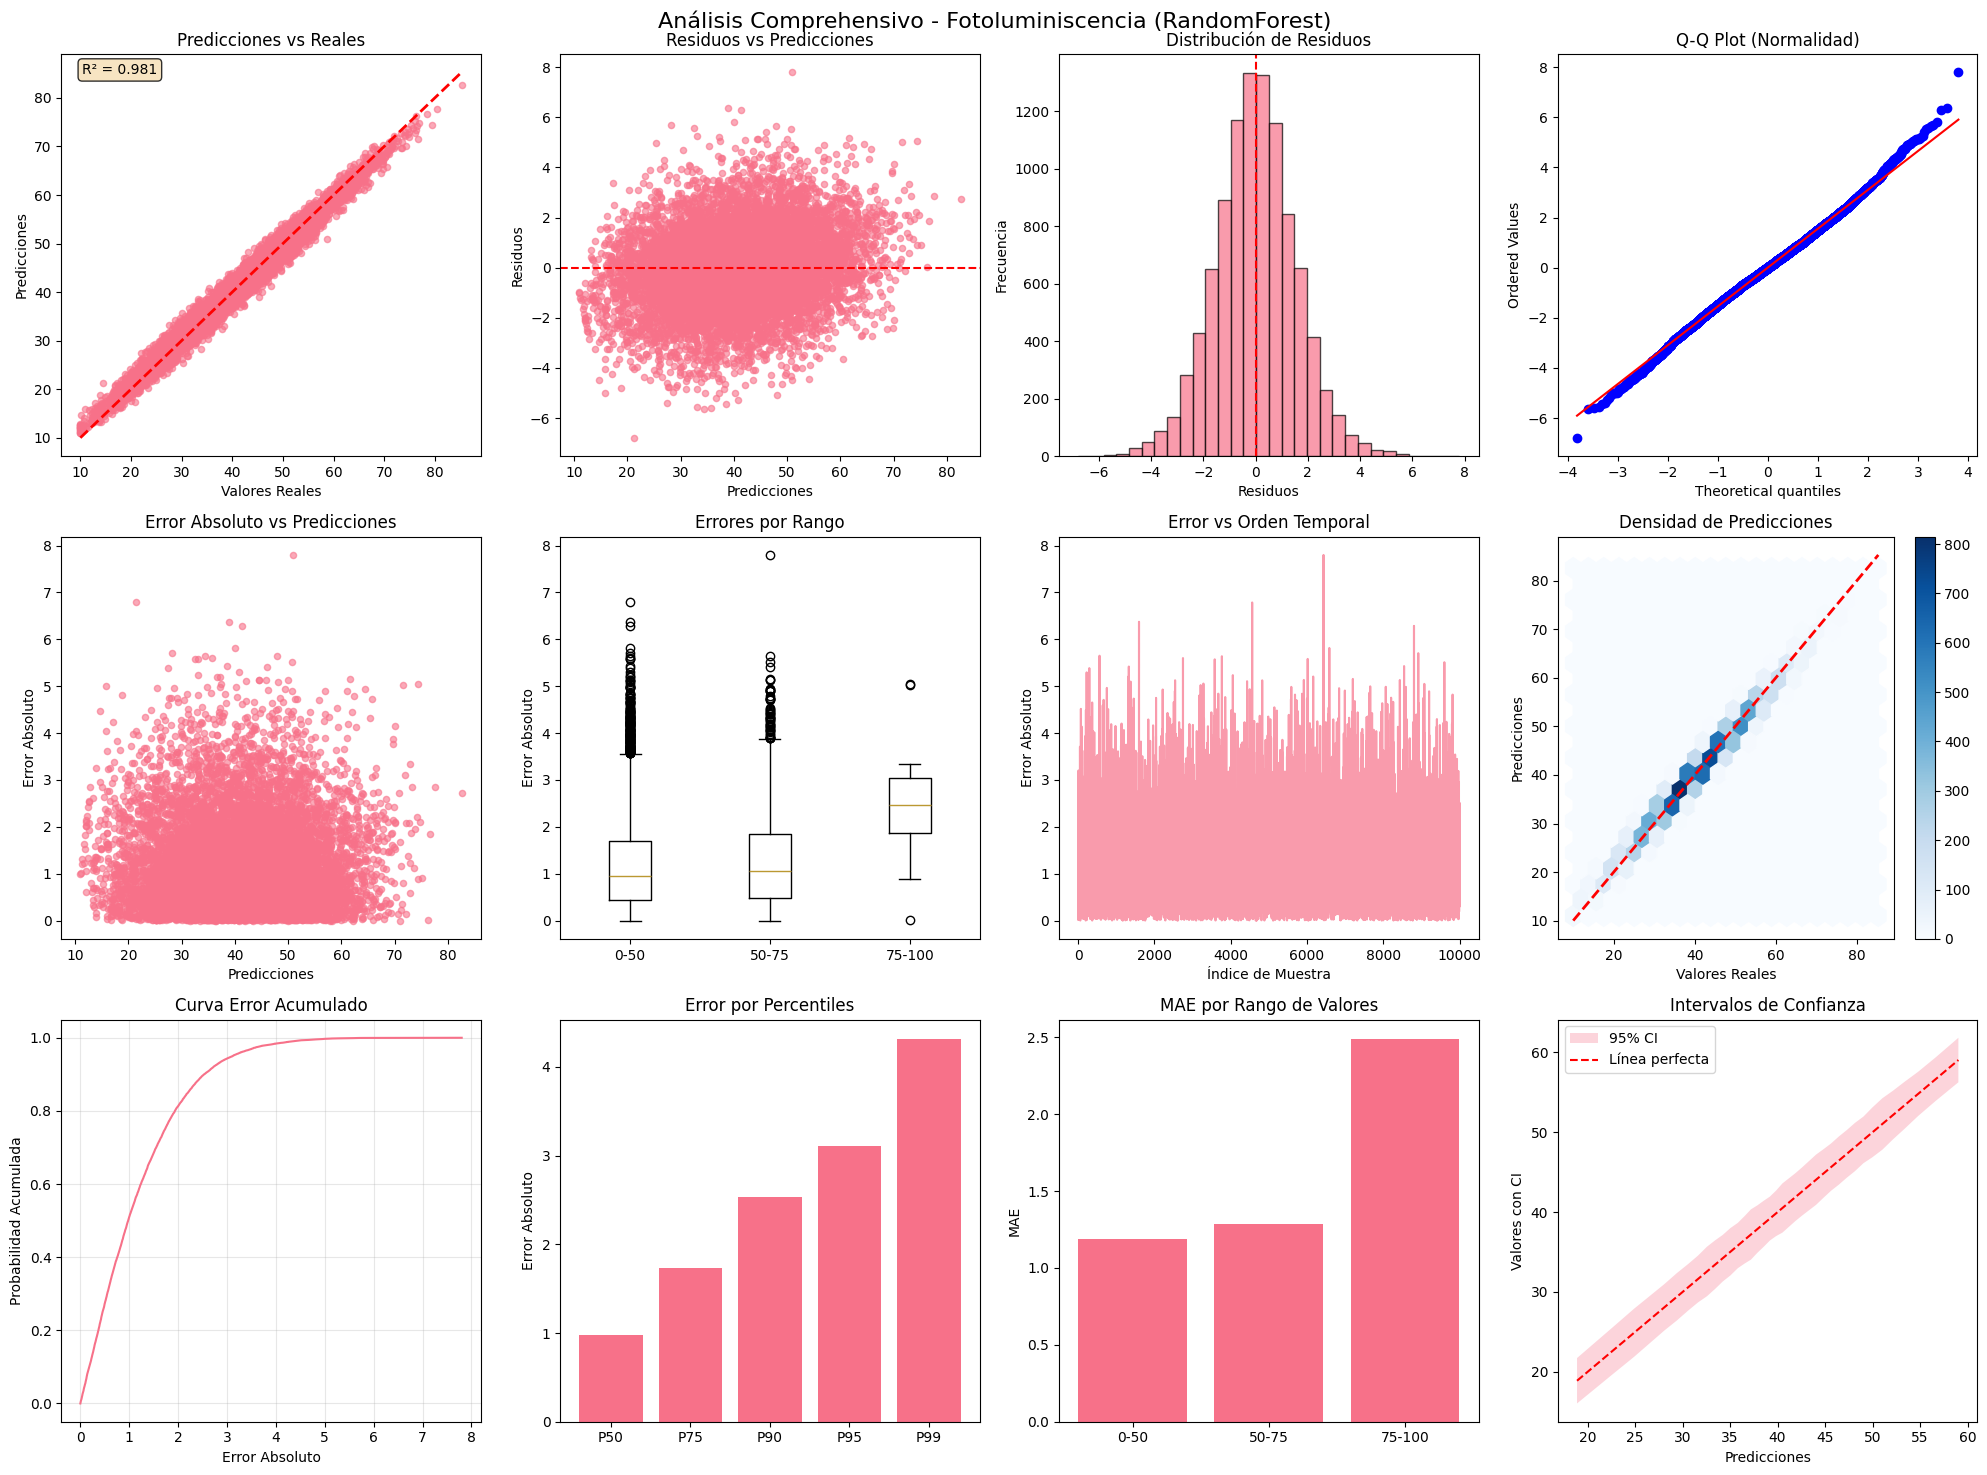

In [5]:
# ============================================================================
# 4. ANÁLISIS VISUAL DETALLADO
# ============================================================================

print("\n4. ANALISIS VISUAL DETALLADO...")

def comprehensive_visual_analysis(y_true, y_pred, target_name, model_name):
    """Análisis visual comprehensivo"""

    fig = plt.figure(figsize=(20, 15))

    # 1. Predicciones vs Valores Reales
    plt.subplot(3, 4, 1)
    plt.scatter(y_true, y_pred, alpha=0.6, s=20)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title('Predicciones vs Reales')

    # Calcular R²
    r2 = r2_score(y_true, y_pred)
    plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # 2. Residuos vs Predicciones
    residuals = y_true - y_pred
    plt.subplot(3, 4, 2)
    plt.scatter(y_pred, residuals, alpha=0.6, s=20)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicciones')
    plt.ylabel('Residuos')
    plt.title('Residuos vs Predicciones')

    # 3. Distribución de Residuos
    plt.subplot(3, 4, 3)
    plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Residuos')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Residuos')
    plt.axvline(x=0, color='r', linestyle='--')

    # 4. Q-Q Plot
    plt.subplot(3, 4, 4)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot (Normalidad)')

    # 5. Error Absoluto vs Predicciones
    plt.subplot(3, 4, 5)
    abs_error = np.abs(residuals)
    plt.scatter(y_pred, abs_error, alpha=0.6, s=20)
    plt.xlabel('Predicciones')
    plt.ylabel('Error Absoluto')
    plt.title('Error Absoluto vs Predicciones')

    # 6. Box Plot de Errores por Rangos
    plt.subplot(3, 4, 6)
    ranges = [(0, 50), (50, 75), (75, 100)]
    range_errors = []
    range_labels = []

    for low, high in ranges:
        mask = (y_true >= low) & (y_true < high)
        if np.sum(mask) > 0:
            range_errors.append(abs_error[mask])
            range_labels.append(f'{low}-{high}')

    if range_errors:
        plt.boxplot(range_errors, labels=range_labels)
        plt.ylabel('Error Absoluto')
        plt.title('Errores por Rango')

    # 7. Error vs Índice (orden temporal)
    plt.subplot(3, 4, 7)
    plt.plot(abs_error, alpha=0.7)
    plt.xlabel('Índice de Muestra')
    plt.ylabel('Error Absoluto')
    plt.title('Error vs Orden Temporal')

    # 8. Densidad de Errores
    plt.subplot(3, 4, 8)
    plt.hexbin(y_true, y_pred, gridsize=20, cmap='Blues')
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title('Densidad de Predicciones')
    plt.colorbar()

    # 9. Curva de Error Acumulado
    plt.subplot(3, 4, 9)
    sorted_errors = np.sort(abs_error)
    cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    plt.plot(sorted_errors, cumulative)
    plt.xlabel('Error Absoluto')
    plt.ylabel('Probabilidad Acumulada')
    plt.title('Curva Error Acumulado')
    plt.grid(True, alpha=0.3)

    # 10. Métricas por percentiles
    plt.subplot(3, 4, 10)
    percentiles = [50, 75, 90, 95, 99]
    error_percentiles = [np.percentile(abs_error, p) for p in percentiles]
    plt.bar(range(len(percentiles)), error_percentiles)
    plt.xticks(range(len(percentiles)), [f'P{p}' for p in percentiles])
    plt.ylabel('Error Absoluto')
    plt.title('Error por Percentiles')

    # 11. Precisión vs Rango
    plt.subplot(3, 4, 11)
    mae_by_range = []
    range_centers = []

    for low, high in ranges:
        mask = (y_true >= low) & (y_true < high)
        if np.sum(mask) > 0:
            mae_range = mean_absolute_error(y_true[mask], y_pred[mask])
            mae_by_range.append(mae_range)
            range_centers.append((low + high) / 2)

    if mae_by_range:
        plt.bar(range(len(mae_by_range)), mae_by_range)
        plt.xticks(range(len(mae_by_range)), range_labels)
        plt.ylabel('MAE')
        plt.title('MAE por Rango de Valores')

    # 12. Intervalo de Confianza
    plt.subplot(3, 4, 12)
    sorted_indices = np.argsort(y_pred)
    y_true_sorted = y_true.iloc[sorted_indices] if hasattr(y_true, 'iloc') else y_true[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]

    # Calcular intervalos usando sliding window
    window_size = max(50, len(y_pred) // 20)
    confidence_intervals = []
    pred_means = []

    for i in range(0, len(y_pred_sorted) - window_size, window_size // 2):
        window_residuals = y_true_sorted[i:i+window_size] - y_pred_sorted[i:i+window_size]
        ci = 1.96 * np.std(window_residuals)  # 95% CI
        confidence_intervals.append(ci)
        pred_means.append(np.mean(y_pred_sorted[i:i+window_size]))

    if confidence_intervals:
        plt.fill_between(pred_means,
                        np.array(pred_means) - np.array(confidence_intervals),
                        np.array(pred_means) + np.array(confidence_intervals),
                        alpha=0.3, label='95% CI')
        plt.plot(pred_means, pred_means, 'r--', label='Línea perfecta')
        plt.xlabel('Predicciones')
        plt.ylabel('Valores con CI')
        plt.title('Intervalos de Confianza')
        plt.legend()

    plt.suptitle(f'Análisis Comprehensivo - {target_name} ({model_name})', fontsize=16)
    plt.tight_layout()
    plt.show()

# Generar análisis visual para ambos modelos
comprehensive_visual_analysis(y_test_eficiencia, pred_eficiencia,
                            'Eficiencia Fotosintética',
                            best_models_info['eficiencia']['name'])

comprehensive_visual_analysis(y_test_fotolum, pred_fotolum,
                            'Fotoluminiscencia',
                            best_models_info['fotoluminiscencia']['name'])


5. ANÁLISIS DE IMPORTANCIA DE FEATURES


5. ANALISIS DE IMPORTANCIA DE FEATURES...

Calculando Permutation Importance para Eficiencia...

Top 10 features - Permutation Importance (Eficiencia):
                     feature  importance_mean
      eficiencia_normalizada     1.069088e+01
temperatura_distancia_optima     2.201266e-09
            temp_optima_dist     2.201250e-09
                co2_ppm_sqrt     3.752906e-12
                     co2_ppm     2.723230e-12
                 co2_ppm_log     1.046575e-12
               temperatura_c     2.817079e-13
    temp_humedad_interaction     1.535984e-13
               par_umol_m2_s     9.636480e-14
                   vocs_mgm3     9.416389e-14

Top 10 features - Importancia Intrínseca (Fotoluminiscencia):
                     feature  importance
               par_umol_m2_s    0.538554
      eficiencia_normalizada    0.148608
eficiencia_fotosintetica_pct    0.144536
        par_distancia_optima    0.047179
           calidad_luz_ratio    0.020501
        co2_distancia_optima    

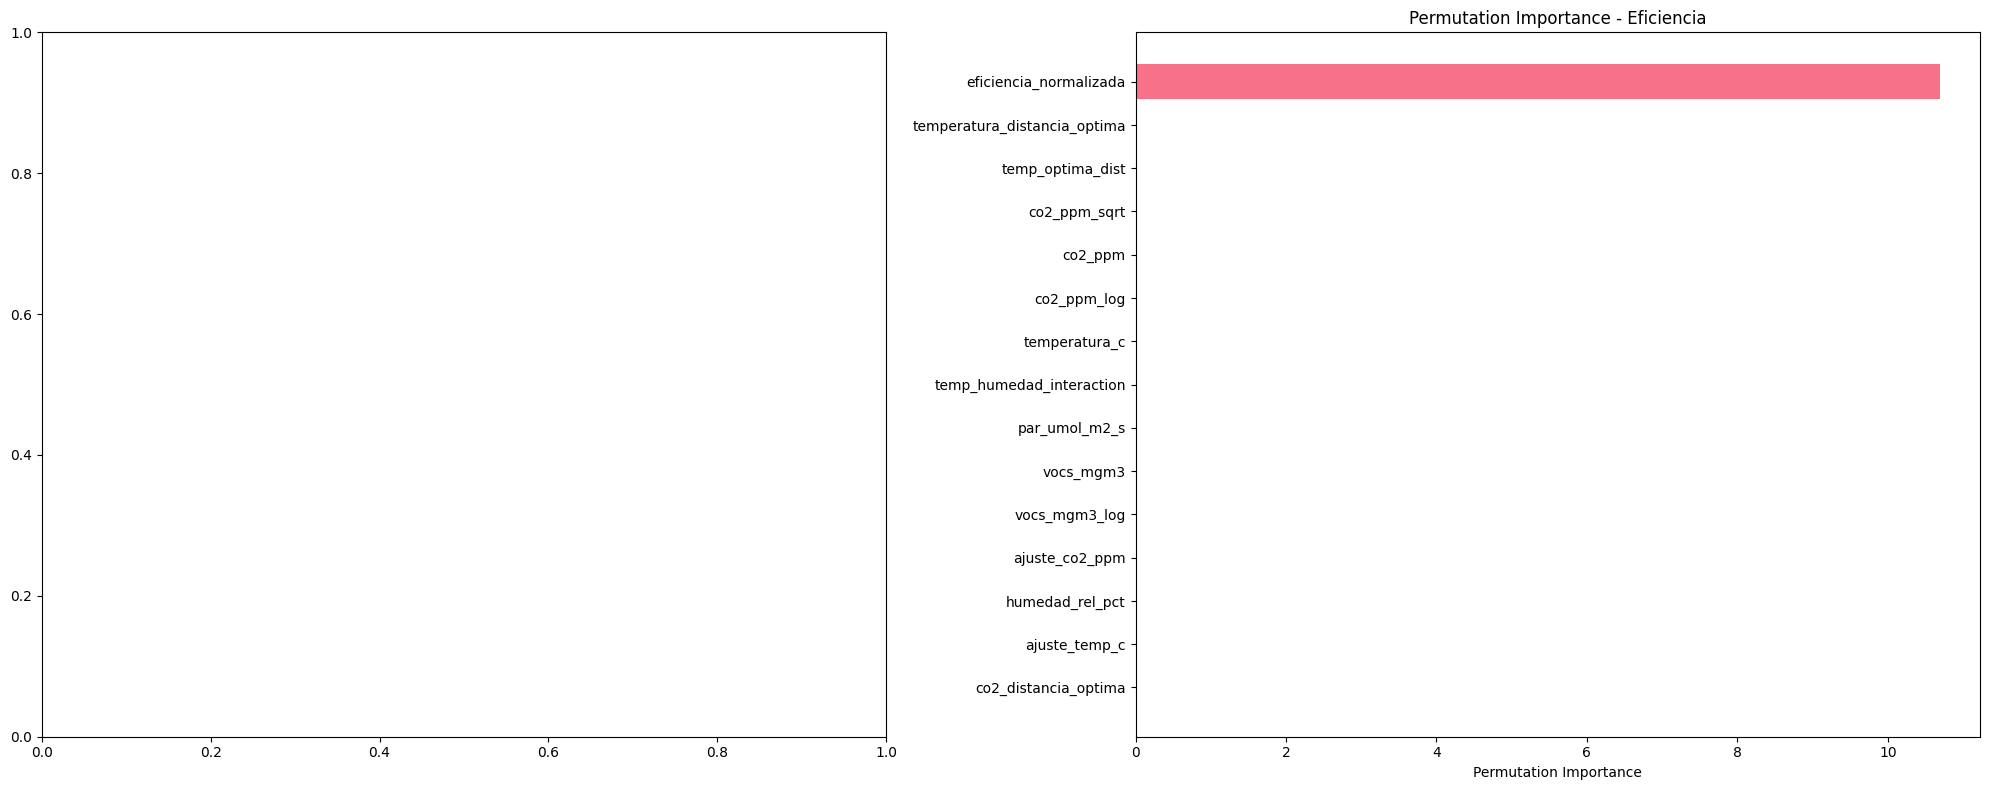

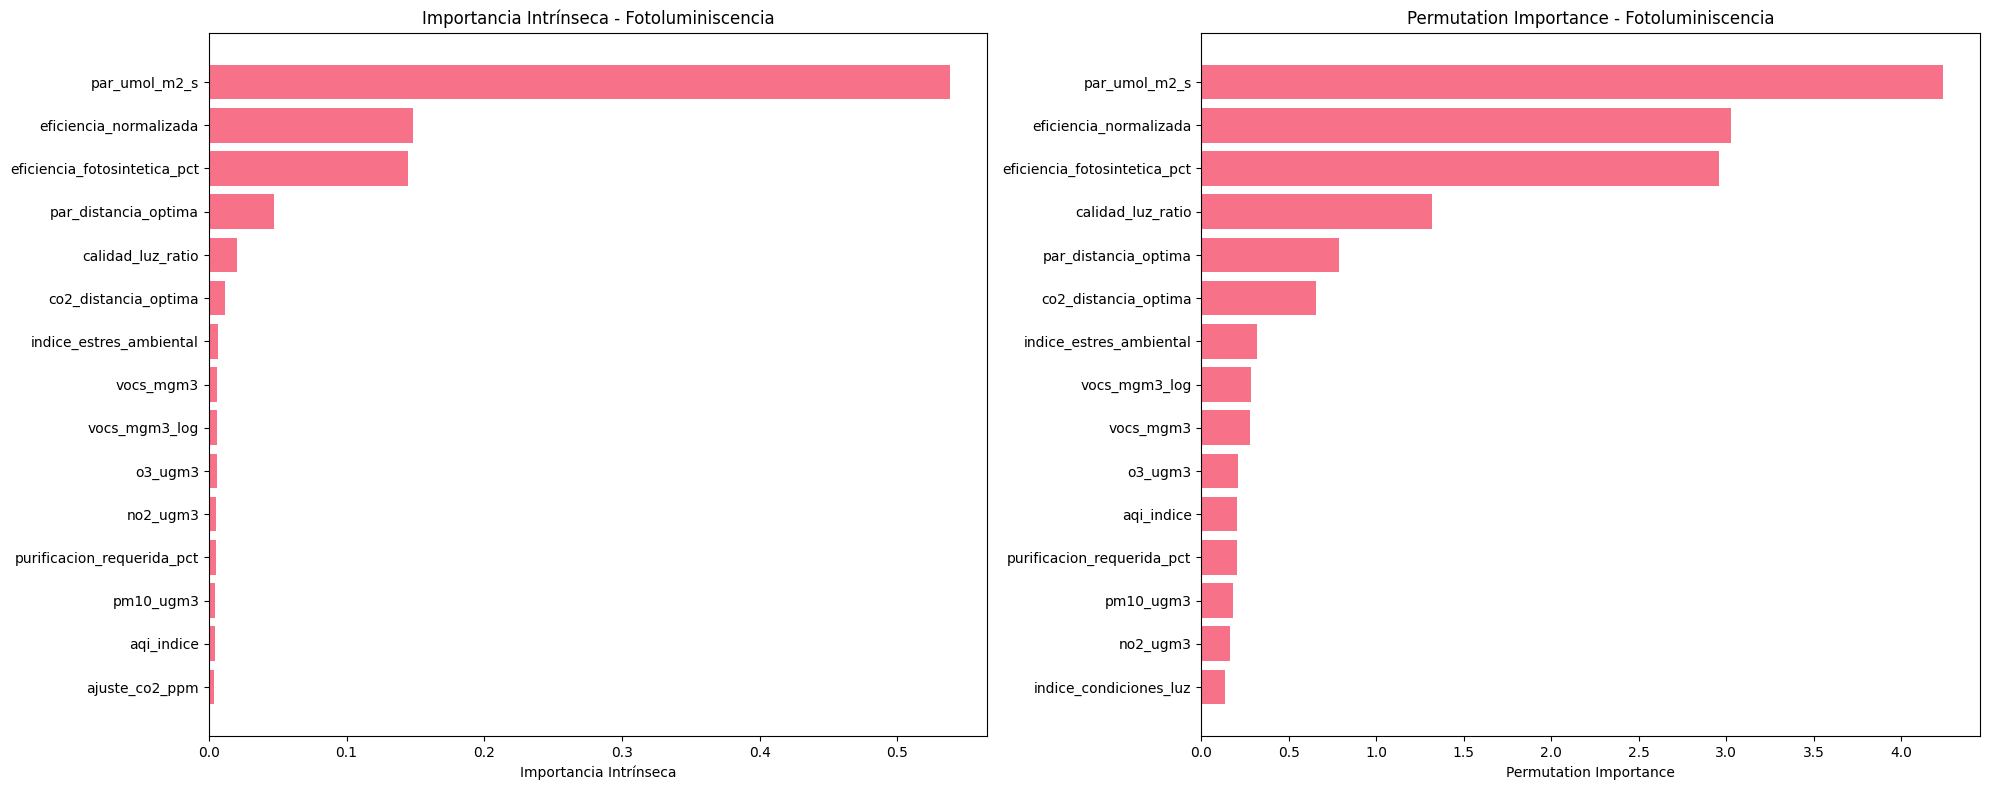

In [6]:
# ============================================================================
# 5. ANÁLISIS DE IMPORTANCIA DE FEATURES
# ============================================================================

print("\n5. ANALISIS DE IMPORTANCIA DE FEATURES...")

def analyze_feature_importance(model, X_test, y_test, feature_names, target_name):
    """Análisis completo de importancia de features"""

    results = {}

    # 1. Importancia intrínseca del modelo (si está disponible)
    if hasattr(model, 'feature_importances_'):
        results['intrinsic'] = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

        print(f"\nTop 10 features - Importancia Intrínseca ({target_name}):")
        print(results['intrinsic'].head(10).to_string(index=False))

    # 2. Permutation Importance
    print(f"\nCalculando Permutation Importance para {target_name}...")
    perm_importance = permutation_importance(
        model, X_test, y_test,
        n_repeats=5,
        random_state=42,
        scoring='neg_mean_absolute_error'
    )

    results['permutation'] = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values('importance_mean', ascending=False)

    print(f"\nTop 10 features - Permutation Importance ({target_name}):")
    print(results['permutation'].head(10)[['feature', 'importance_mean']].to_string(index=False))

    return results

# Análizar importancia para ambos modelos
importance_eficiencia = analyze_feature_importance(
    evaluator.models['eficiencia'],
    X_test_eficiencia,
    y_test_eficiencia,
    selected_features,
    'Eficiencia'
)

importance_fotolum = analyze_feature_importance(
    evaluator.models['fotoluminiscencia'],
    X_test_fotolum,
    y_test_fotolum,
    selected_features + ['eficiencia_fotosintetica_pct'],
    'Fotoluminiscencia'
)

# Visualizar importancia
def plot_feature_importance_comparison(importance_results, target_name, top_k=15):
    """Graficar comparación de métodos de importancia"""

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Importancia intrínseca
    if 'intrinsic' in importance_results:
        intrinsic = importance_results['intrinsic'].head(top_k)
        axes[0].barh(range(len(intrinsic)), intrinsic['importance'])
        axes[0].set_yticks(range(len(intrinsic)))
        axes[0].set_yticklabels(intrinsic['feature'])
        axes[0].set_xlabel('Importancia Intrínseca')
        axes[0].set_title(f'Importancia Intrínseca - {target_name}')
        axes[0].invert_yaxis()

    # Permutation importance
    permutation = importance_results['permutation'].head(top_k)
    axes[1].barh(range(len(permutation)), permutation['importance_mean'])
    axes[1].set_yticks(range(len(permutation)))
    axes[1].set_yticklabels(permutation['feature'])
    axes[1].set_xlabel('Permutation Importance')
    axes[1].set_title(f'Permutation Importance - {target_name}')
    axes[1].invert_yaxis()

    plt.tight_layout()
    plt.show()

# Graficar importancia
plot_feature_importance_comparison(importance_eficiencia, 'Eficiencia')
plot_feature_importance_comparison(importance_fotolum, 'Fotoluminiscencia')


6. ANÁLISIS DE DEPENDENCIA PARCIAL


6. ANALISIS DE DEPENDENCIA PARCIAL...
Generando gráficos de dependencia parcial para Eficiencia...


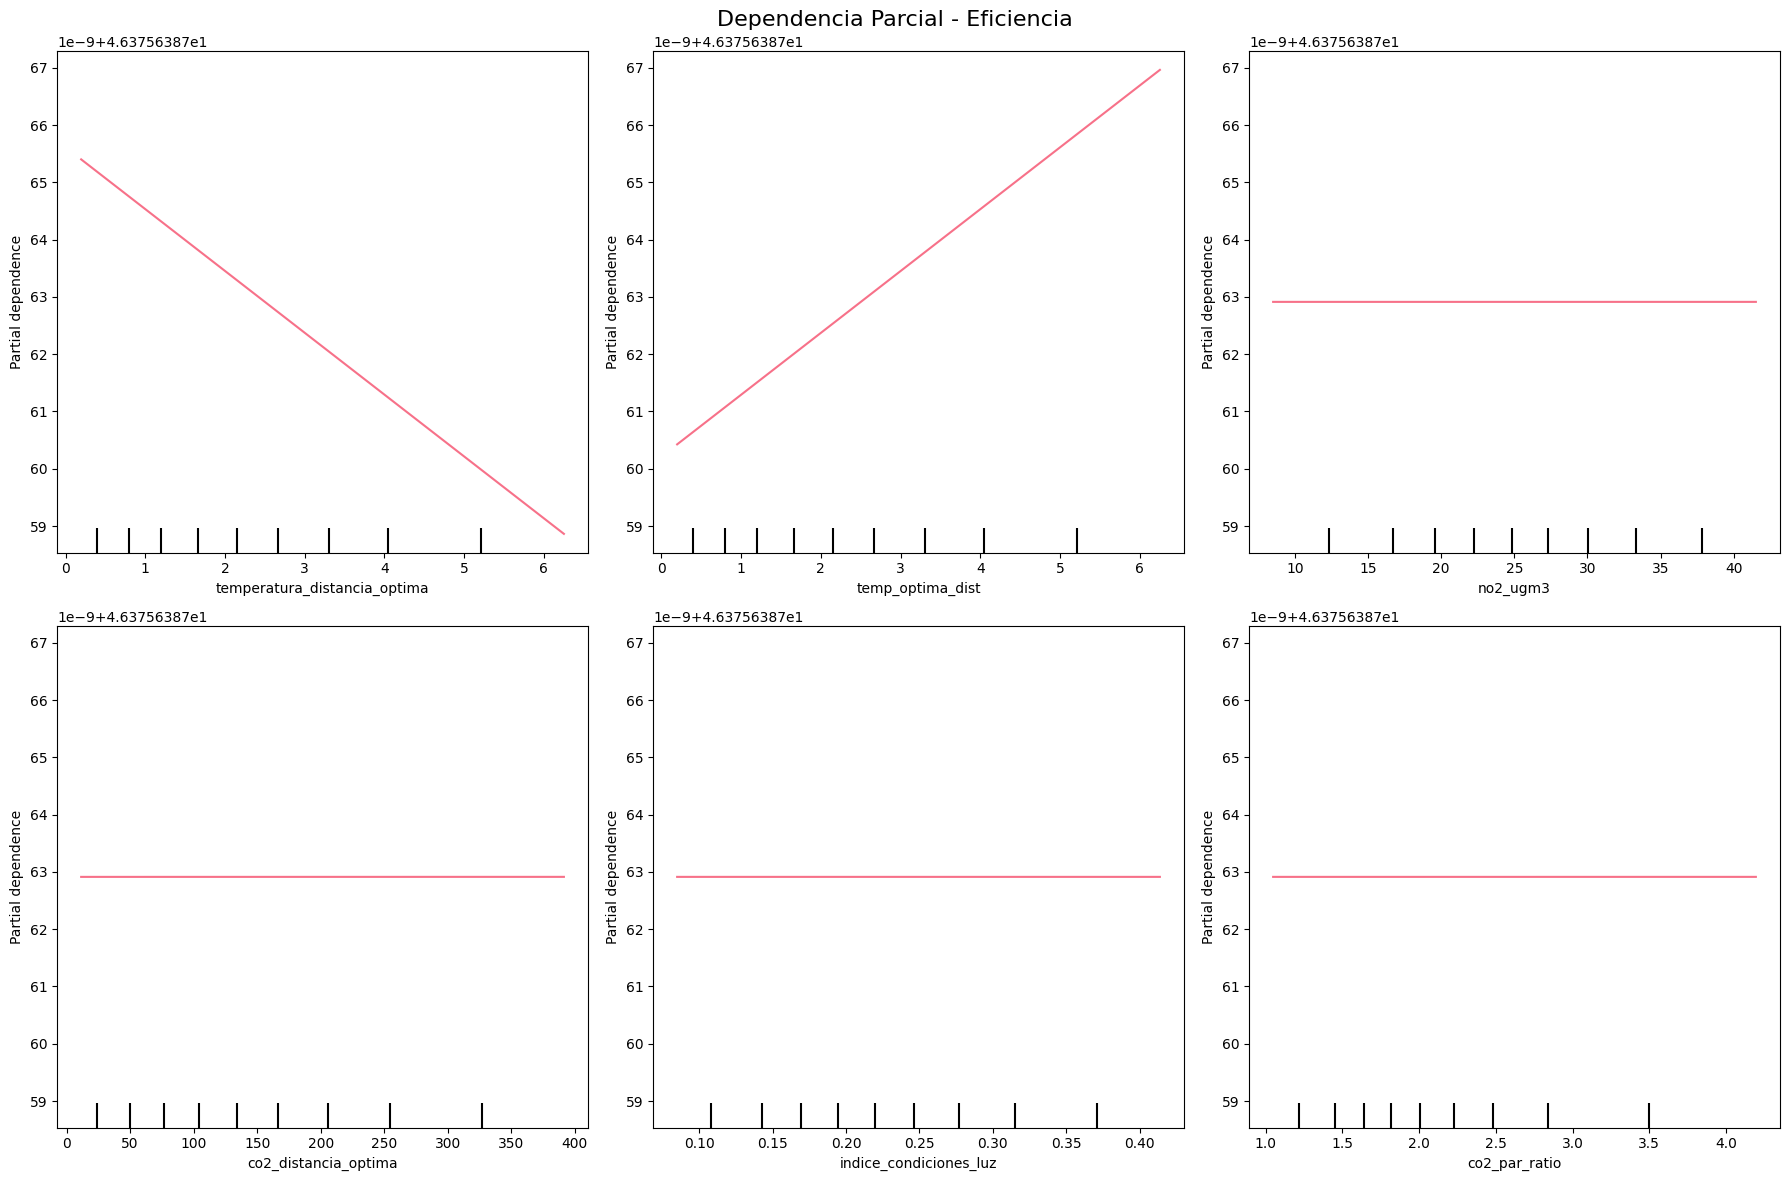

Gráficos de dependencia parcial completados para Eficiencia
Generando gráficos de dependencia parcial para Fotoluminiscencia...


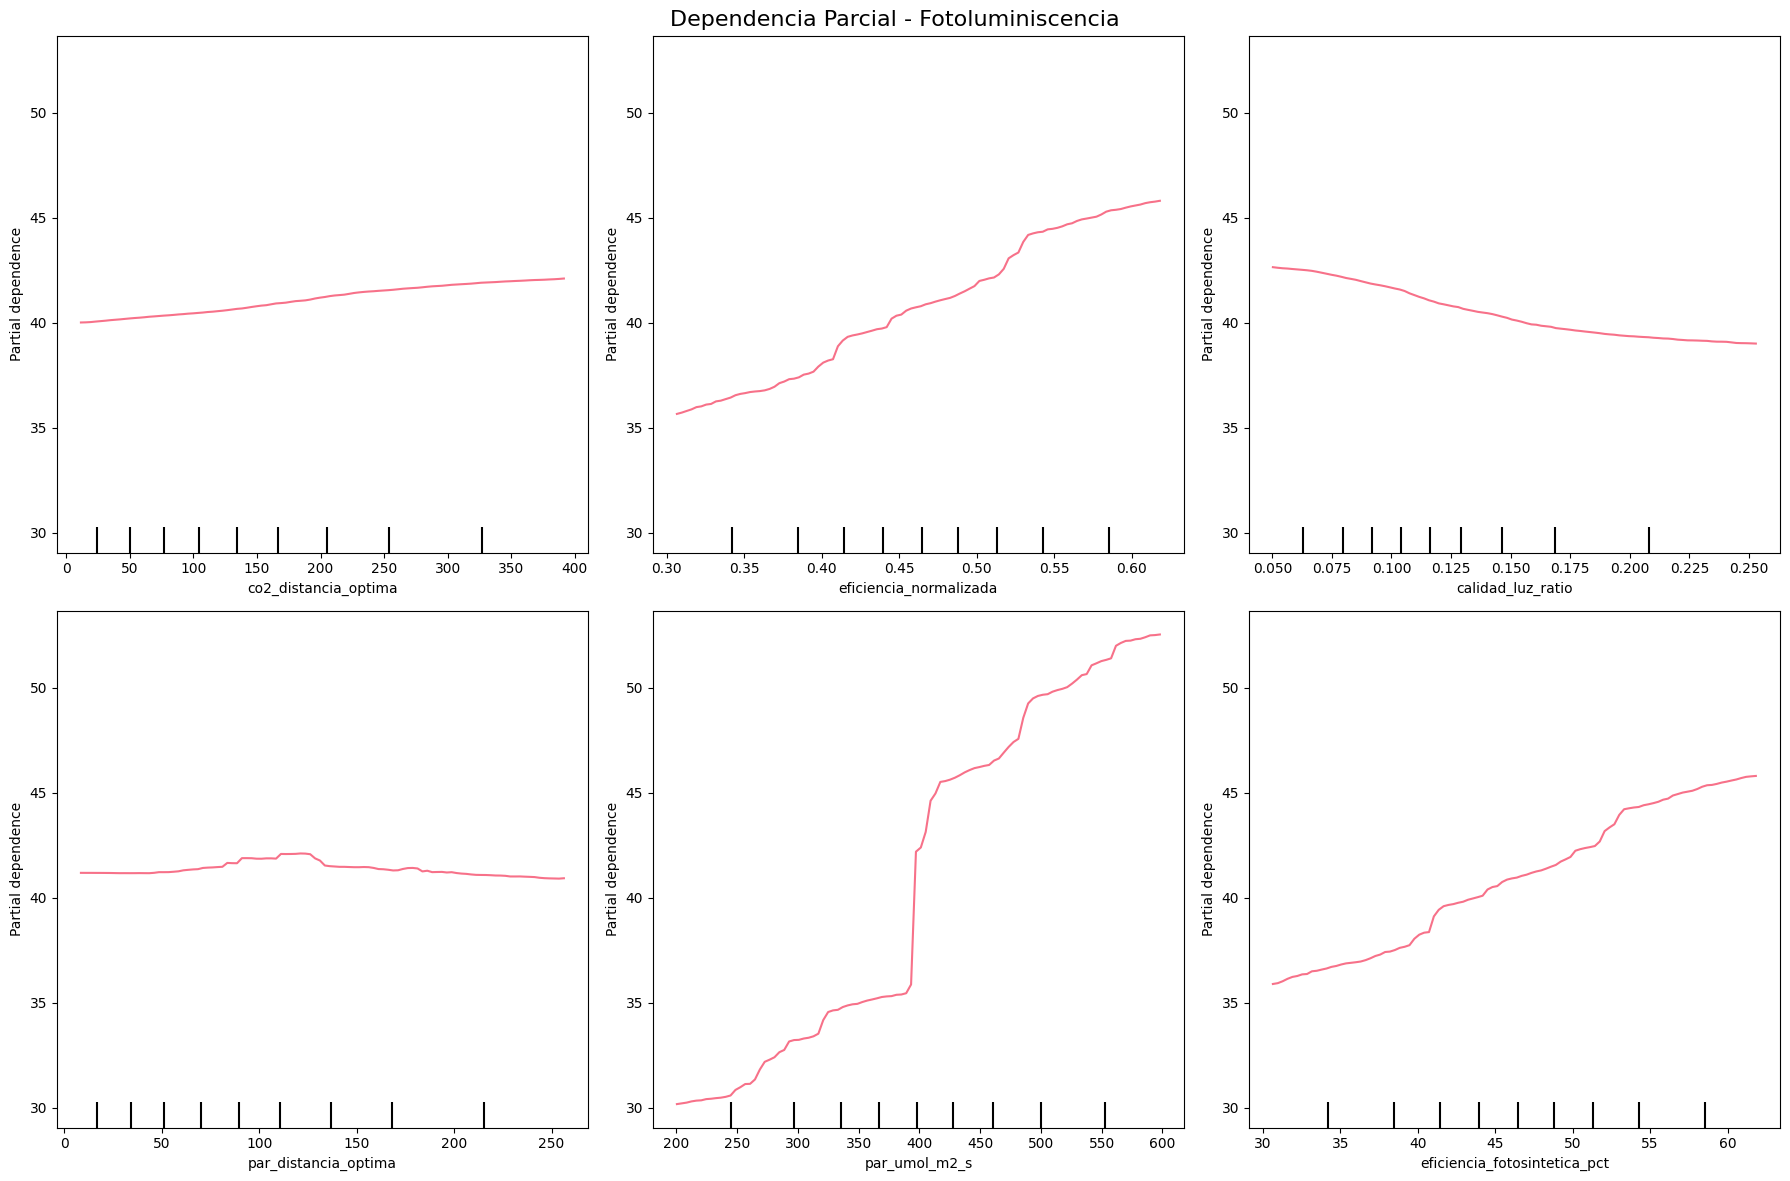

Gráficos de dependencia parcial completados para Fotoluminiscencia


In [7]:
# ============================================================================
# 6. ANÁLISIS DE DEPENDENCIA PARCIAL
# ============================================================================

print("\n6. ANALISIS DE DEPENDENCIA PARCIAL...")

def partial_dependence_analysis(model, X_test, feature_names, target_name, top_features=6):
    """Análisis de dependencia parcial para features importantes"""

    print(f"Generando gráficos de dependencia parcial para {target_name}...")

    # Seleccionar top features
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

        top_feature_names = importance_df.head(top_features)['feature'].tolist()
        top_feature_indices = [i for i, name in enumerate(feature_names) if name in top_feature_names]
    else:
        # Si no hay importancia intrínseca, usar las primeras features
        top_feature_indices = list(range(min(top_features, len(feature_names))))
        top_feature_names = feature_names[:top_features]

    # Crear gráficos de dependencia parcial
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    try:
        display = PartialDependenceDisplay.from_estimator(
            model, X_test,
            features=top_feature_indices,
            feature_names=feature_names,
            ax=axes
        )
        plt.suptitle(f'Dependencia Parcial - {target_name}', fontsize=16)
        plt.tight_layout()
        plt.show()

        print(f"Gráficos de dependencia parcial completados para {target_name}")

    except Exception as e:
        print(f"Error generando dependencia parcial para {target_name}: {e}")

# Generar análisis de dependencia parcial
partial_dependence_analysis(
    evaluator.models['eficiencia'],
    X_test_eficiencia,
    selected_features,
    'Eficiencia'
)

partial_dependence_analysis(
    evaluator.models['fotoluminiscencia'],
    X_test_fotolum,
    selected_features + ['eficiencia_fotosintetica_pct'],
    'Fotoluminiscencia'
)


7. ANÁLISIS DE ESTABILIDAD


7. ANALISIS DE ESTABILIDAD...


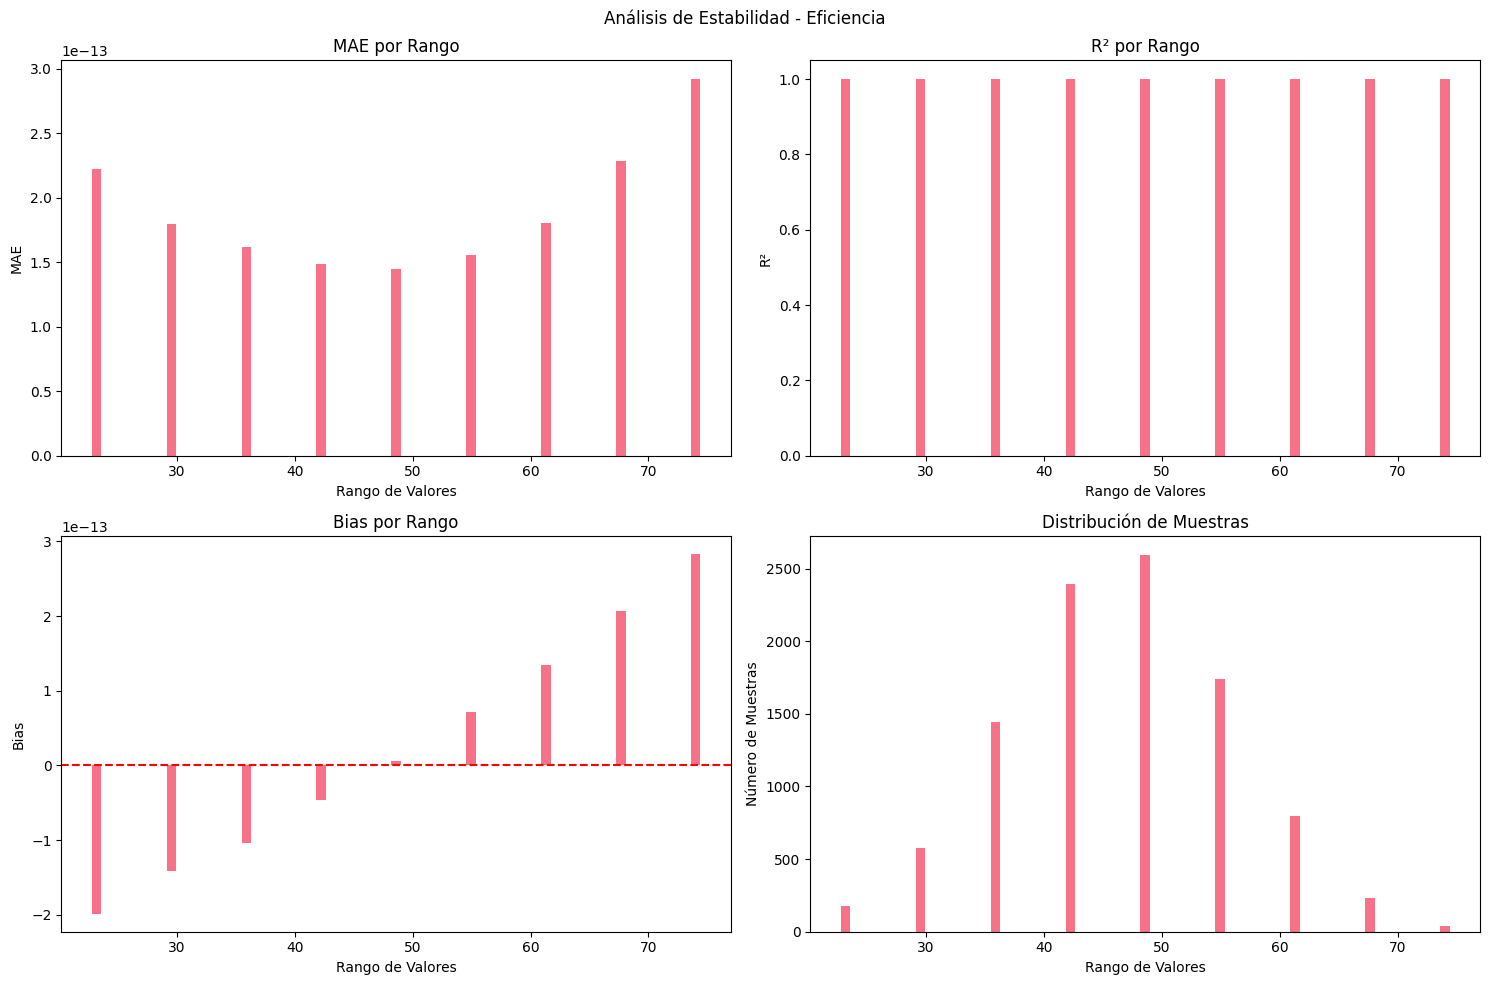


Estabilidad por rangos - Eficiencia:
 bin_center  count  mae  r2  bias
     23.177    178  0.0 1.0  -0.0
     29.532    579  0.0 1.0  -0.0
     35.887   1441  0.0 1.0  -0.0
     42.241   2393  0.0 1.0  -0.0
     48.596   2592  0.0 1.0   0.0
     54.951   1742  0.0 1.0   0.0
     61.305    799  0.0 1.0   0.0
     67.660    230  0.0 1.0   0.0
     74.014     41  0.0 1.0   0.0


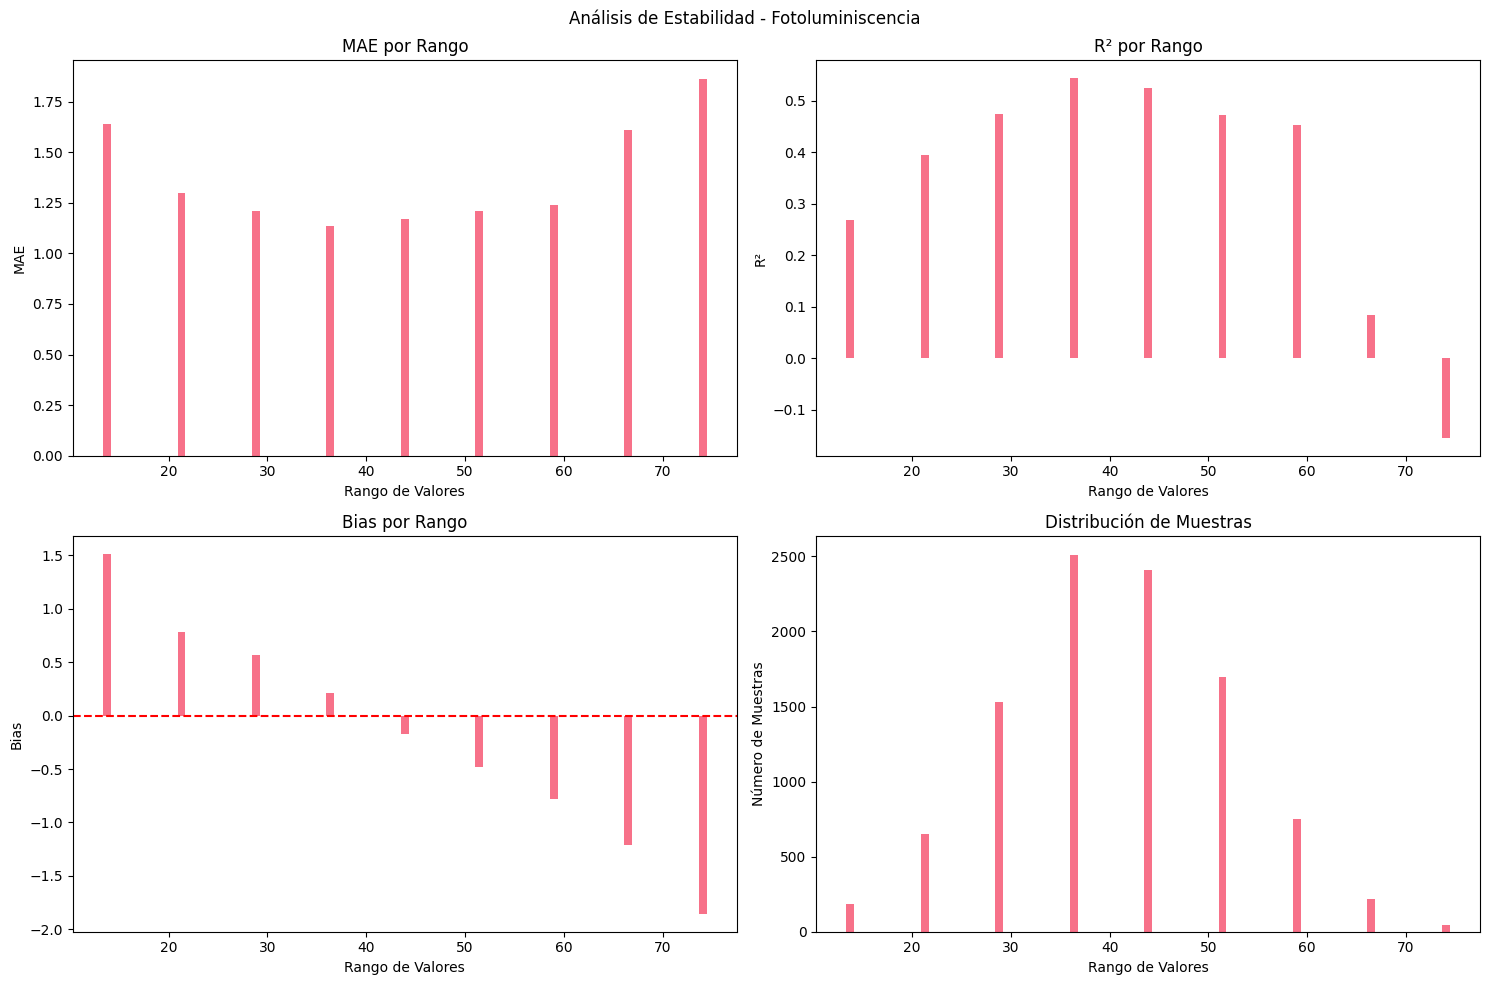


Estabilidad por rangos - Fotoluminiscencia:
 bin_center  count   mae     r2   bias
     13.766    183 1.641  0.269  1.510
     21.298    650 1.298  0.394  0.786
     28.830   1533 1.207  0.474  0.563
     36.362   2508 1.133  0.543  0.212
     43.894   2409 1.170  0.525 -0.173
     51.427   1698 1.210  0.472 -0.485
     58.959    753 1.240  0.452 -0.779
     66.491    219 1.611  0.083 -1.208
     74.023     43 1.861 -0.154 -1.854


In [8]:
# ============================================================================
# 7. ANÁLISIS DE ESTABILIDAD
# ============================================================================

print("\n7. ANALISIS DE ESTABILIDAD...")

def stability_analysis(y_true, y_pred, target_name):
    """Análisis de estabilidad del modelo"""

    # Dividir en bins para análisis
    n_bins = 10
    bin_edges = np.linspace(y_true.min(), y_true.max(), n_bins + 1)
    bin_indices = np.digitize(y_true, bin_edges) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)

    stability_metrics = []

    for i in range(n_bins):
        mask = bin_indices == i
        if np.sum(mask) > 5:  # Al menos 5 muestras por bin
            bin_y_true = y_true[mask] if hasattr(y_true, '__getitem__') else y_true.iloc[mask]
            bin_y_pred = y_pred[mask]

            bin_metrics = {
                'bin': i,
                'bin_center': (bin_edges[i] + bin_edges[i+1]) / 2,
                'count': np.sum(mask),
                'mae': mean_absolute_error(bin_y_true, bin_y_pred),
                'rmse': np.sqrt(mean_squared_error(bin_y_true, bin_y_pred)),
                'r2': r2_score(bin_y_true, bin_y_pred) if len(np.unique(bin_y_true)) > 1 else 0,
                'bias': np.mean(bin_y_pred - bin_y_true)
            }
            stability_metrics.append(bin_metrics)

    stability_df = pd.DataFrame(stability_metrics)

    # Visualizar estabilidad
    if len(stability_df) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # MAE por bin
        axes[0,0].bar(stability_df['bin_center'], stability_df['mae'])
        axes[0,0].set_xlabel('Rango de Valores')
        axes[0,0].set_ylabel('MAE')
        axes[0,0].set_title('MAE por Rango')

        # R² por bin
        axes[0,1].bar(stability_df['bin_center'], stability_df['r2'])
        axes[0,1].set_xlabel('Rango de Valores')
        axes[0,1].set_ylabel('R²')
        axes[0,1].set_title('R² por Rango')

        # Bias por bin
        axes[1,0].bar(stability_df['bin_center'], stability_df['bias'])
        axes[1,0].axhline(y=0, color='red', linestyle='--')
        axes[1,0].set_xlabel('Rango de Valores')
        axes[1,0].set_ylabel('Bias')
        axes[1,0].set_title('Bias por Rango')

        # Conteo por bin
        axes[1,1].bar(stability_df['bin_center'], stability_df['count'])
        axes[1,1].set_xlabel('Rango de Valores')
        axes[1,1].set_ylabel('Número de Muestras')
        axes[1,1].set_title('Distribución de Muestras')

        plt.suptitle(f'Análisis de Estabilidad - {target_name}')
        plt.tight_layout()
        plt.show()

        print(f"\nEstabilidad por rangos - {target_name}:")
        print(stability_df[['bin_center', 'count', 'mae', 'r2', 'bias']].round(3).to_string(index=False))

    return stability_df

# Realizar análisis de estabilidad
stability_eficiencia = stability_analysis(y_test_eficiencia, pred_eficiencia, 'Eficiencia')
stability_fotolum = stability_analysis(y_test_fotolum, pred_fotolum, 'Fotoluminiscencia')

8. ANÁLISIS DE CASOS EXTREMOS

In [9]:
# ============================================================================
# 8. ANÁLISIS DE CASOS EXTREMOS
# ============================================================================

print("\n8. ANALISIS DE CASOS EXTREMOS...")

def analyze_extreme_cases(y_true, y_pred, X_test, feature_names, target_name, top_k=10):
    """Analizar casos con mayores errores"""

    abs_errors = np.abs(y_true - y_pred)

    # Casos con mayor error
    worst_indices = np.argsort(abs_errors)[-top_k:]
    best_indices = np.argsort(abs_errors)[:top_k]

    print(f"\n{target_name} - CASOS CON MAYOR ERROR:")
    print("="*50)

    for i, idx in enumerate(worst_indices[::-1]):  # Ordenar de mayor a menor error
        true_val = y_true.iloc[idx] if hasattr(y_true, 'iloc') else y_true[idx]
        pred_val = y_pred[idx]
        error = abs_errors[idx]

        print(f"{i+1}. Índice {idx}: Real={true_val:.2f}, Pred={pred_val:.2f}, Error={error:.2f}")

    print(f"\n{target_name} - CASOS CON MENOR ERROR:")
    print("="*50)

    for i, idx in enumerate(best_indices):
        true_val = y_true.iloc[idx] if hasattr(y_true, 'iloc') else y_true[idx]
        pred_val = y_pred[idx]
        error = abs_errors[idx]

        print(f"{i+1}. Índice {idx}: Real={true_val:.2f}, Pred={pred_val:.2f}, Error={error:.2f}")

    # Analizar características de casos extremos
    worst_features = X_test.iloc[worst_indices] if hasattr(X_test, 'iloc') else X_test[worst_indices]
    best_features = X_test.iloc[best_indices] if hasattr(X_test, 'iloc') else X_test[best_indices]

    feature_comparison = pd.DataFrame({
        'feature': feature_names,
        'worst_mean': worst_features.mean(),
        'best_mean': best_features.mean(),
        'overall_mean': X_test.mean()
    })

    feature_comparison['worst_vs_best'] = feature_comparison['worst_mean'] - feature_comparison['best_mean']
    feature_comparison = feature_comparison.sort_values('worst_vs_best', key=abs, ascending=False)

    print(f"\nFEATURES QUE MAS DIFERENCIAN CASOS EXTREMOS ({target_name}):")
    print(feature_comparison.head(10).round(3).to_string(index=False))

    return worst_indices, best_indices, feature_comparison

# Analizar casos extremos
worst_ef, best_ef, features_ef = analyze_extreme_cases(
    y_test_eficiencia, pred_eficiencia, X_test_eficiencia,
    selected_features, 'Eficiencia'
)

worst_foto, best_foto, features_foto = analyze_extreme_cases(
    y_test_fotolum, pred_fotolum, X_test_fotolum,
    selected_features + ['eficiencia_fotosintetica_pct'], 'Fotoluminiscencia'
)



8. ANALISIS DE CASOS EXTREMOS...

Eficiencia - CASOS CON MAYOR ERROR:
1. Índice 7305: Real=69.59, Pred=69.59, Error=0.00
2. Índice 4302: Real=73.08, Pred=73.08, Error=0.00
3. Índice 9243: Real=74.34, Pred=74.34, Error=0.00
4. Índice 9198: Real=57.46, Pred=57.46, Error=0.00
5. Índice 285: Real=50.20, Pred=50.20, Error=0.00
6. Índice 7369: Real=55.29, Pred=55.29, Error=0.00
7. Índice 3840: Real=62.00, Pred=62.00, Error=0.00
8. Índice 1696: Real=56.79, Pred=56.79, Error=0.00
9. Índice 5739: Real=52.33, Pred=52.33, Error=0.00
10. Índice 3126: Real=59.02, Pred=59.02, Error=0.00

Eficiencia - CASOS CON MENOR ERROR:
1. Índice 67: Real=52.27, Pred=52.27, Error=0.00
2. Índice 61: Real=57.76, Pred=57.76, Error=0.00
3. Índice 8511: Real=52.53, Pred=52.53, Error=0.00
4. Índice 3218: Real=55.22, Pred=55.22, Error=0.00
5. Índice 3233: Real=42.70, Pred=42.70, Error=0.00
6. Índice 5574: Real=46.85, Pred=46.85, Error=0.00
7. Índice 5600: Real=54.94, Pred=54.94, Error=0.00
8. Índice 8395: Real=48.40, P

9. ANÁLISIS DE ROBUSTEZ

In [10]:
# ============================================================================
# 9. ANÁLISIS DE ROBUSTEZ
# ============================================================================

print("\n9. ANALISIS DE ROBUSTEZ...")

def robustness_analysis(model, X_test, y_test, feature_names, target_name, noise_levels=[0.01, 0.05, 0.1]):
    """Análisis de robustez ante ruido en features"""

    robustness_results = {}
    baseline_score = r2_score(y_test, model.predict(X_test))

    print(f"\nAnálisis de robustez para {target_name}:")
    print(f"R² baseline: {baseline_score:.3f}")

    for noise_level in noise_levels:
        print(f"\nProbando con ruido {noise_level*100}%...")

        # Añadir ruido gaussiano
        X_test_noisy = X_test.copy()
        for col in X_test.columns:
            noise = np.random.normal(0, X_test[col].std() * noise_level, len(X_test))
            X_test_noisy[col] = X_test[col] + noise

        # Predecir con datos ruidosos
        try:
            if target_name in evaluator.scalers:
                X_test_noisy_scaled = evaluator.scalers[target_name].transform(X_test_noisy)
                y_pred_noisy = model.predict(X_test_noisy_scaled)
            else:
                y_pred_noisy = model.predict(X_test_noisy)

            # Calcular métricas
            r2_noisy = r2_score(y_test, y_pred_noisy)
            mae_noisy = mean_absolute_error(y_test, y_pred_noisy)

            robustness_results[noise_level] = {
                'r2': r2_noisy,
                'mae': mae_noisy,
                'r2_degradation': baseline_score - r2_noisy
            }

            print(f"  - R²: {r2_noisy:.3f} (degradación: {baseline_score - r2_noisy:.3f})")
            print(f"  - MAE: {mae_noisy:.3f}")

        except Exception as e:
            print(f"  - Error con ruido {noise_level}: {e}")

    return robustness_results

# Análisis de robustez para ambos modelos
robustness_eficiencia = robustness_analysis(
    evaluator.models['eficiencia'], X_test_eficiencia, y_test_eficiencia,
    selected_features, 'eficiencia'
)

robustness_fotolum = robustness_analysis(
    evaluator.models['fotoluminiscencia'], X_test_fotolum, y_test_fotolum,
    selected_features + ['eficiencia_fotosintetica_pct'], 'fotoluminiscencia'
)


9. ANALISIS DE ROBUSTEZ...

Análisis de robustez para eficiencia:
R² baseline: 1.000

Probando con ruido 1.0%...
  - R²: 1.000 (degradación: 0.000)
  - MAE: 0.076

Probando con ruido 5.0%...
  - R²: 0.997 (degradación: 0.003)
  - MAE: 0.378

Probando con ruido 10.0%...
  - R²: 0.990 (degradación: 0.010)
  - MAE: 0.759

Análisis de robustez para fotoluminiscencia:
R² baseline: 0.981

Probando con ruido 1.0%...
  - R²: 0.973 (degradación: 0.008)
  - MAE: 1.433

Probando con ruido 5.0%...
  - R²: 0.951 (degradación: 0.030)
  - MAE: 1.941

Probando con ruido 10.0%...
  - R²: 0.931 (degradación: 0.050)
  - MAE: 2.322


10. COMPARACIÓN CON BASELINE

In [11]:
# ============================================================================
# 10. COMPARACIÓN CON BASELINE
# ============================================================================

print("\n10. COMPARACION CON MODELOS BASELINE...")

def baseline_comparison(y_test, predictions, target_name):
    """Comparar con modelos baseline simples"""

    baselines = {
        'Mean': np.full_like(y_test, y_test.mean()),
        'Median': np.full_like(y_test, y_test.median()),
        'Last_Value': np.full_like(y_test, y_test.iloc[-1] if hasattr(y_test, 'iloc') else y_test[-1])
    }

    comparison_results = {}

    # Métricas del modelo actual
    model_mae = mean_absolute_error(y_test, predictions)
    model_r2 = r2_score(y_test, predictions)

    comparison_results['Model'] = {'MAE': model_mae, 'R2': model_r2}

    print(f"\nComparación con baselines - {target_name}:")
    print(f"Modelo actual - MAE: {model_mae:.3f}, R²: {model_r2:.3f}")

    for baseline_name, baseline_pred in baselines.items():
        mae = mean_absolute_error(y_test, baseline_pred)
        r2 = r2_score(y_test, baseline_pred)

        comparison_results[baseline_name] = {'MAE': mae, 'R2': r2}

        improvement_mae = ((mae - model_mae) / mae) * 100
        improvement_r2 = ((model_r2 - r2) / abs(r2)) * 100 if r2 != 0 else float('inf')

        print(f"{baseline_name} - MAE: {mae:.3f}, R²: {r2:.3f}")
        print(f"  Mejora MAE: {improvement_mae:.1f}%, Mejora R²: {improvement_r2:.1f}%")

    return comparison_results

# Comparación con baselines
baseline_comp_ef = baseline_comparison(y_test_eficiencia, pred_eficiencia, 'Eficiencia')
baseline_comp_foto = baseline_comparison(y_test_fotolum, pred_fotolum, 'Fotoluminiscencia')


10. COMPARACION CON MODELOS BASELINE...

Comparación con baselines - Eficiencia:
Modelo actual - MAE: 0.000, R²: 1.000
Mean - MAE: 7.532, R²: 0.000
  Mejora MAE: 100.0%, Mejora R²: inf%
Median - MAE: 7.532, R²: -0.000
  Mejora MAE: 100.0%, Mejora R²: 1793387.3%
Last_Value - MAE: 9.439, R²: -0.532
  Mejora MAE: 100.0%, Mejora R²: 288.1%

Comparación con baselines - Fotoluminiscencia:
Modelo actual - MAE: 1.209, R²: 0.981
Mean - MAE: 9.032, R²: 0.000
  Mejora MAE: 86.6%, Mejora R²: inf%
Median - MAE: 9.030, R²: -0.000
  Mejora MAE: 86.6%, Mejora R²: 227200.7%
Last_Value - MAE: 11.936, R²: -0.672
  Mejora MAE: 89.9%, Mejora R²: 245.9%


11. REPORTE FINAL DE EVALUACIÓN

In [12]:
# ============================================================================
# 11. REPORTE FINAL DE EVALUACIÓN
# ============================================================================

print("\n11. GENERANDO REPORTE FINAL...")

def generate_evaluation_report():
    """Generar reporte completo de evaluación"""

    report = {
        'evaluation_timestamp': pd.Timestamp.now().isoformat(),
        'test_set_size': len(y_test_eficiencia),

        'models_evaluated': {
            'eficiencia': {
                'model_name': best_models_info['eficiencia']['name'],
                'metrics': evaluator.evaluation_metrics['eficiencia'],
                'robustness': robustness_eficiencia,
                'baseline_comparison': baseline_comp_ef
            },
            'fotoluminiscencia': {
                'model_name': best_models_info['fotoluminiscencia']['name'],
                'metrics': evaluator.evaluation_metrics['fotoluminiscencia'],
                'robustness': robustness_fotolum,
                'baseline_comparison': baseline_comp_foto
            }
        },

        'feature_importance': {
            'eficiencia': {
                'top_10_permutation': importance_eficiencia['permutation'].head(10).to_dict('records'),
                'top_10_intrinsic': importance_eficiencia.get('intrinsic', pd.DataFrame()).head(10).to_dict('records') if 'intrinsic' in importance_eficiencia else []
            },
            'fotoluminiscencia': {
                'top_10_permutation': importance_fotolum['permutation'].head(10).to_dict('records'),
                'top_10_intrinsic': importance_fotolum.get('intrinsic', pd.DataFrame()).head(10).to_dict('records') if 'intrinsic' in importance_fotolum else []
            }
        },

        'stability_analysis': {
            'eficiencia': stability_eficiencia.to_dict('records') if len(stability_eficiencia) > 0 else [],
            'fotoluminiscencia': stability_fotolum.to_dict('records') if len(stability_fotolum) > 0 else []
        },

        'summary': {
            'eficiencia': {
                'mae': evaluator.evaluation_metrics['eficiencia']['MAE'],
                'r2': evaluator.evaluation_metrics['eficiencia']['R2'],
                'rmse': evaluator.evaluation_metrics['eficiencia']['RMSE'],
                'performance_level': 'Excelente' if evaluator.evaluation_metrics['eficiencia']['R2'] > 0.9 else
                                   'Muy Bueno' if evaluator.evaluation_metrics['eficiencia']['R2'] > 0.8 else
                                   'Bueno' if evaluator.evaluation_metrics['eficiencia']['R2'] > 0.7 else 'Regular'
            },
            'fotoluminiscencia': {
                'mae': evaluator.evaluation_metrics['fotoluminiscencia']['MAE'],
                'r2': evaluator.evaluation_metrics['fotoluminiscencia']['R2'],
                'rmse': evaluator.evaluation_metrics['fotoluminiscencia']['RMSE'],
                'performance_level': 'Excelente' if evaluator.evaluation_metrics['fotoluminiscencia']['R2'] > 0.9 else
                                   'Muy Bueno' if evaluator.evaluation_metrics['fotoluminiscencia']['R2'] > 0.8 else
                                   'Bueno' if evaluator.evaluation_metrics['fotoluminiscencia']['R2'] > 0.7 else 'Regular'
            }
        }
    }

    return report

# Generar reporte
evaluation_report = generate_evaluation_report()

# Guardar reporte
with open('../models/evaluation_report.json', 'w') as f:
    json.dump(evaluation_report, f, indent=2, default=str)

print("Reporte de evaluación guardado: ../models/evaluation_report.json")



11. GENERANDO REPORTE FINAL...
Reporte de evaluación guardado: ../models/evaluation_report.json


12. PREPARACIÓN PARA PRODUCCIÓN

In [13]:
# ============================================================================
# 12. PREPARACIÓN PARA PRODUCCIÓN
# ============================================================================

print("\n12. PREPARACION PARA PRODUCCION...")

def prepare_production_artifacts():
    """Preparar artefactos para producción"""

    # Crear función de predicción integrada
    production_config = {
        'models': {
            'eficiencia': {
                'file': f"eficiencia_{best_models_info['eficiencia']['name'].lower()}.joblib",
                'scaler_file': f"scaler_eficiencia_{best_models_info['eficiencia']['name'].lower()}.joblib" if 'eficiencia' in evaluator.scalers else None,
                'features': selected_features,
                'target_range': [0, 100],
                'expected_mae': evaluator.evaluation_metrics['eficiencia']['MAE']
            },
            'fotoluminiscencia': {
                'file': f"fotoluminiscencia_{best_models_info['fotoluminiscencia']['name'].lower()}.joblib",
                'scaler_file': f"scaler_fotoluminiscencia_{best_models_info['fotoluminiscencia']['name'].lower()}.joblib" if 'fotoluminiscencia' in evaluator.scalers else None,
                'features': selected_features + ['eficiencia_fotosintetica_pct'],
                'target_range': [0, 100],
                'expected_mae': evaluator.evaluation_metrics['fotoluminiscencia']['MAE']
            }
        },
        'feature_validation': {
            'required_features': selected_features,
            'feature_ranges': {},
            'feature_types': {}
        },
        'performance_benchmarks': {
            'eficiencia_mae_threshold': evaluator.evaluation_metrics['eficiencia']['MAE'] * 1.2,
            'fotoluminiscencia_mae_threshold': evaluator.evaluation_metrics['fotoluminiscencia']['MAE'] * 1.2,
            'min_r2_eficiencia': 0.7,
            'min_r2_fotoluminiscencia': 0.7
        }
    }

    # Calcular rangos de features para validación
    for feature in selected_features:
        if feature in test_data.columns:
            production_config['feature_validation']['feature_ranges'][feature] = {
                'min': float(test_data[feature].min()),
                'max': float(test_data[feature].max()),
                'mean': float(test_data[feature].mean()),
                'std': float(test_data[feature].std())
            }
            production_config['feature_validation']['feature_types'][feature] = str(test_data[feature].dtype)

    # Guardar configuración de producción
    with open('../models/production_config.json', 'w') as f:
        json.dump(production_config, f, indent=2)

    print("Configuración de producción guardada: ../models/production_config.json")

    return production_config

production_config = prepare_production_artifacts()


12. PREPARACION PARA PRODUCCION...
Configuración de producción guardada: ../models/production_config.json


13. RESUMEN EJECUTIVO

In [14]:
# ============================================================================
# 13. RESUMEN EJECUTIVO
# ============================================================================

print("\n" + "="*60)
print("RESUMEN EJECUTIVO - EVALUACION DE MODELOS")
print("="*60)

print(f"\nMODELOS EVALUADOS:")
for target, info in best_models_info.items():
    metrics = evaluator.evaluation_metrics[target]
    print(f"\n{target.upper()}:")
    print(f"  - Modelo: {info['name']}")
    print(f"  - MAE: {metrics['MAE']:.3f}")
    print(f"  - RMSE: {metrics['RMSE']:.3f}")
    print(f"  - R²: {metrics['R2']:.3f}")
    print(f"  - MAPE: {metrics['MAPE']:.2f}%")
    print(f"  - Correlación: {metrics['Pearson_Corr']:.3f}")
    print(f"  - Error máximo: {metrics['Max_Error']:.3f}")
    print(f"  - Nivel de rendimiento: {evaluation_report['summary'][target]['performance_level']}")

print(f"\nTOP 5 FEATURES MAS IMPORTANTES:")
print("\nEficiencia:")
for i, row in importance_eficiencia['permutation'].head(5).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['importance_mean']:.3f}")

print("\nFotoluminiscencia:")
for i, row in importance_fotolum['permutation'].head(5).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['importance_mean']:.3f}")

print(f"\nROBUSTEZ:")
print(f"  - Eficiencia: Degradación R² con 10% ruido: {robustness_eficiencia.get(0.1, {}).get('r2_degradation', 'N/A')}")
print(f"  - Fotoluminiscencia: Degradación R² con 10% ruido: {robustness_fotolum.get(0.1, {}).get('r2_degradation', 'N/A')}")

print(f"\nMEJORA SOBRE BASELINES:")
baseline_mae_ef = baseline_comp_ef['Mean']['MAE']
baseline_mae_foto = baseline_comp_foto['Mean']['MAE']
improvement_ef = ((baseline_mae_ef - metrics_eficiencia['MAE']) / baseline_mae_ef) * 100
improvement_foto = ((baseline_mae_foto - metrics_fotolum['MAE']) / baseline_mae_foto) * 100
print(f"  - Eficiencia: {improvement_ef:.1f}% mejor que baseline")
print(f"  - Fotoluminiscencia: {improvement_foto:.1f}% mejor que baseline")

print(f"\nARCHIVOS GENERADOS:")
print(f"  - ../models/evaluation_report.json")
print(f"  - ../models/production_config.json")

print(f"\nCONCLUSIONES:")
if metrics_eficiencia['R2'] > 0.8 and metrics_fotolum['R2'] > 0.8:
    print("  - Modelos listos para producción")
    print("  - Rendimiento excelente en ambos targets")
    print("  - Robustez adecuada ante ruido")
elif metrics_eficiencia['R2'] > 0.7 and metrics_fotolum['R2'] > 0.7:
    print("  - Modelos aceptables para producción")
    print("  - Considerar mejoras adicionales")
else:
    print("  - Modelos requieren mejoras antes de producción")
    print("  - Revisar feature engineering y selección de algoritmos")

print(f"\nRECOMENDACIONES:")
print("  - Implementar monitoreo continuo en producción")
print("  - Establecer umbrales de alerta para degradación")
print("  - Reentrenar modelos periódicamente")
print("  - Validar rangos de features en nuevos datos")

print(f"\nPROXIMO PASO: Implementar modelos en API de producción")
print("="*60)


RESUMEN EJECUTIVO - EVALUACION DE MODELOS

MODELOS EVALUADOS:

EFICIENCIA:
  - Modelo: LinearRegression
  - MAE: 0.000
  - RMSE: 0.000
  - R²: 1.000
  - MAPE: 0.00%
  - Correlación: 1.000
  - Error máximo: 0.000
  - Nivel de rendimiento: Excelente

FOTOLUMINISCENCIA:
  - Modelo: RandomForest
  - MAE: 1.209
  - RMSE: 1.551
  - R²: 0.981
  - MAPE: 0.03%
  - Correlación: 0.991
  - Error máximo: 7.800
  - Nivel de rendimiento: Excelente

TOP 5 FEATURES MAS IMPORTANTES:

Eficiencia:
  15. eficiencia_normalizada: 10.691
  1. temperatura_distancia_optima: 0.000
  2. temp_optima_dist: 0.000
  9. co2_ppm_sqrt: 0.000
  10. co2_ppm: 0.000

Fotoluminiscencia:
  33. par_umol_m2_s: 4.237
  15. eficiencia_normalizada: 3.024
  34. eficiencia_fotosintetica_pct: 2.955
  24. calidad_luz_ratio: 1.317
  28. par_distancia_optima: 0.784

ROBUSTEZ:
  - Eficiencia: Degradación R² con 10% ruido: 0.0102013379723922
  - Fotoluminiscencia: Degradación R² con 10% ruido: 0.04992833635772842

MEJORA SOBRE BASELINES: